In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch 


In [2]:
#This code will follow https://www.youtube.com/watch?v=P6sfmUTpUmc&ab_channel=AndrejKarpathy
#The idea is to show some useful NN stats for initialization and backprop
#Differently from the lecture, I used a class to define the NN and also I used hooks to keep track of
#some parameters...
# We also define a layer for the gains

In [3]:
#The data here follows from previous lectures, and is not important for the current code

In [4]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
#---------------------------------------------------\\---------------------------\\-----------------------------------------------------------\\----------

In [7]:
class emb(nn.Module):
    
    def __init__(self):
        super(emb,self).__init__()
        weight = torch.randn((27, 10), requires_grad=True)
        self.emb = nn.Parameter(weight)

    def forward(self, tensor):
        x = self.emb[tensor]
        return x.view(x.shape[0], -1)

In [8]:
#The model is also not relevant, what is relevant is the use of batchnorm and the activation function

vocab_size = 27
block_size = 3
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
batch_size = 32
n_embd = 10
g = torch.Generator().manual_seed(2147483647) # for reproducibility

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.emb = emb()
        self.layers = nn.Sequential(
        nn.Linear(10 * block_size, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
        nn.Linear(           n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
        nn.Linear(           n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
        nn.Linear(           n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
        nn.Linear(           n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
        nn.Linear(           n_hidden, vocab_size, bias=False), nn.BatchNorm1d(vocab_size),
        )
    
    def forward(self,x):
        x = self.emb(x)
        x = self.layers(x)
        return x



In [9]:
model = Model()

In [10]:
#Hooks for forward pass

hooks = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    hooks[name] = output.detach()
  return hook

In [11]:
#Hooks for backward grads of activations

grad = {}
def getgrad(name):
  # the hook signature
  def hook(model, input, output):
    grad[name] = output

  return hook

In [12]:
# register forward hooks on the layers of choice
l = [x for x,y  in enumerate(model.layers[:-1]) if isinstance(y,nn.Tanh)]

for x in l:
    h1 =  model.layers[x].register_forward_hook(getActivation(f'Tanh{x}'))
    

layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.53%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 3.16%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 3.03%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.88%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.75%


Text(0.5, 1.0, 'activation distribution')

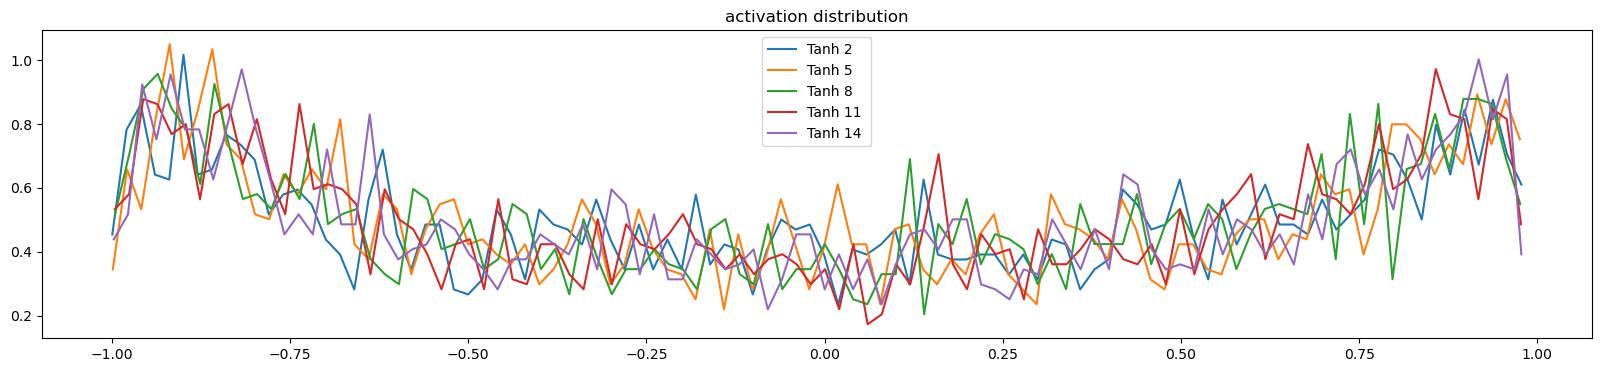

In [13]:
# visualize histograms
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
x = model(Xb)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for x in l: # note: exclude the output layer
    t = hooks[f'Tanh{x}']
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (x, 'Tanh', t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Tanh {x} ')
plt.legend(legends);
plt.title('activation distribution')


In [14]:
# We see that using the batchnorm, we obtain a very stable std, and a low saturation for the tanh, thats good because it means gradients 
#different from 0, also by the stats we see that we will not have so many gradients = 1. 

In [15]:
# If we remove the batchnorm we obtain:

layer 1 (      Tanh): mean -0.02, std 0.46, saturated: 0.06%
layer 3 (      Tanh): mean -0.01, std 0.25, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.14, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.08, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.05, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution without BatchNorm')

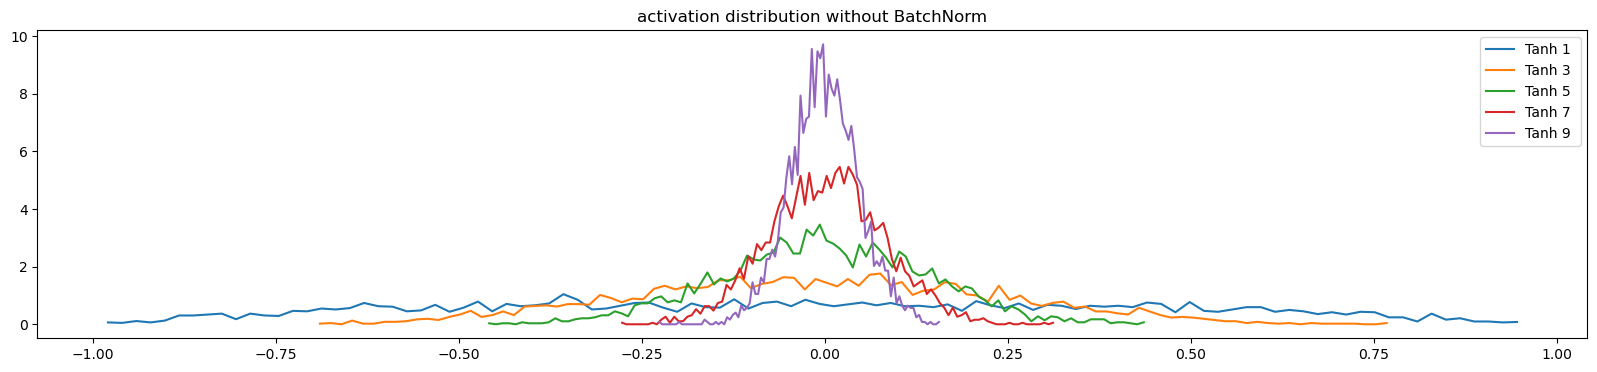

In [75]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for x in l: # note: exclude the output layer
    t = hooks[f'Tanh{x}']
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (x, 'Tanh', t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Tanh {x} ')
plt.legend(legends);
plt.title('activation distribution without BatchNorm')

In [ ]:
# Where we notice a shrinking of the gaussians

In [ ]:
# We could achieve similar results by substituting BatchNorm by the gain using the following layer:

In [56]:
class Multiply(nn.Module):
  """ Calculates the gain and multiply it by the previous output
  
  List of activations are:
  
  tanh
  sigmoid
  relu
  leaky_relu
  selu
  linear
  conv{1,2,3}d
  

  """

  def __init__(self, activation = 'tanh', param = None):
    super(Multiply, self).__init__()
    self.activation = activation
    self.param = param
    self.gain = torch.nn.init.calculate_gain(self.activation, self.param)

  def forward(self, tensors):
    
    return tensors*self.gain

In [16]:
# Activate backward hooks
for x in l:
    h2 =  model.layers[x].register_full_backward_hook(getgrad(f'Tanh{x}'))

In [17]:
#Activate hooks for parameters grad

for x in model.parameters():
    h3 = x[0].requires_grad

In [18]:
epochs = 1
lr = 0.1
ud = []
for i in range(epochs):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    x = model(Xb)
    loss = F.cross_entropy(x, Yb)
    optim = torch.optim.SGD(params = model.parameters(), lr = 0.1)
    optim.zero_grad()
    loss.backward()
    optim.step()
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()]) #This will be used later to measure how fast 
        #is the learing during gradient descent (ratio gradient/data, how big is the step compared to the date)

In [19]:
# Now we will plot the gradient distribution of the activations...

layer 2 (      Tanh): mean +0.000000, std 9.889176e-03
layer 5 (      Tanh): mean +0.000000, std 7.993903e-03
layer 8 (      Tanh): mean +0.000000, std 6.511948e-03
layer 11 (      Tanh): mean -0.000000, std 5.359851e-03
layer 14 (      Tanh): mean +0.000000, std 4.598560e-03


Text(0.5, 1.0, 'gradient distribution')

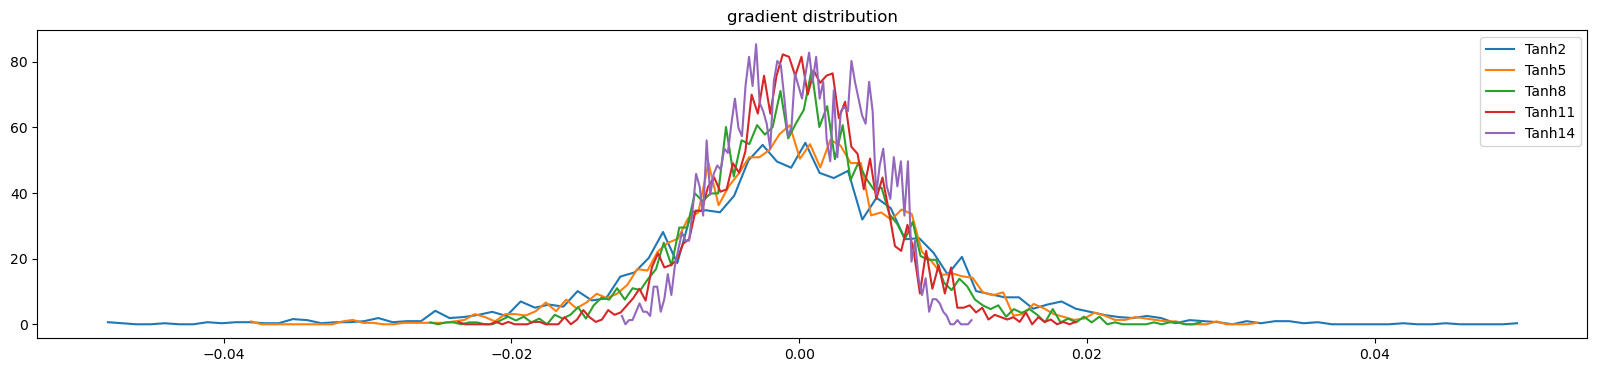

In [20]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for x in l: # note: exclude the output layer
    t = grad[f'Tanh{x}'][0]
    print('layer %d (%10s): mean %+f, std %e' % (x, 'Tanh', t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Tanh{x}')
plt.legend(legends);
plt.title('gradient distribution')

In [ ]:
# We can see that the gradients are very stable... that's expected for a working NN

In [ ]:
# Now we will plot the weights gradient distribution

weight   (27, 10) | mean -0.000000 | std 1.157784e-02 | grad:data ratio 1.226370e-02
weight  (100, 30) | mean +0.000132 | std 1.458471e-02 | grad:data ratio 1.271999e-01
weight (100, 100) | mean -0.000062 | std 9.002683e-03 | grad:data ratio 1.424745e-01
weight (100, 100) | mean -0.000109 | std 7.495411e-03 | grad:data ratio 1.206555e-01
weight (100, 100) | mean -0.000120 | std 7.034590e-03 | grad:data ratio 1.150195e-01
weight (100, 100) | mean +0.000075 | std 6.404718e-03 | grad:data ratio 1.049362e-01
weight  (27, 100) | mean -0.000073 | std 1.226397e-02 | grad:data ratio 1.671428e-01


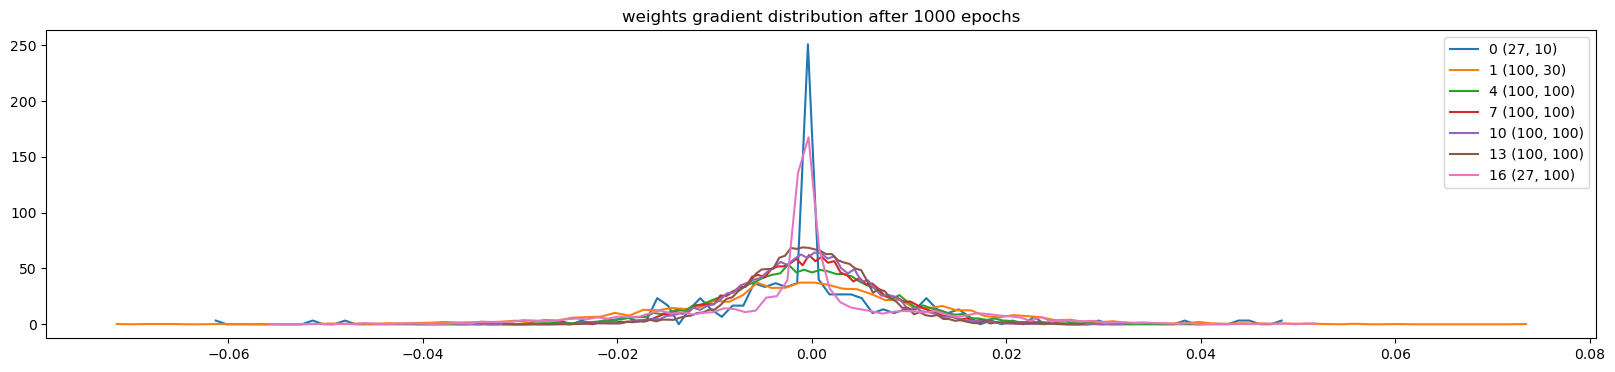

In [25]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters()):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())) #grad;data should be small
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution after 1000 epochs');

In [ ]:
# These are also very stable, exept for the last layers... this graph can be very dynamic for more epochs, and will improve

In [ ]:
#Now we plot our ud, the measument of speed during learning on gradient descent (ratio gradient/data, how big is the step compared to the date)
#Ideal is 1e-3

In [22]:
model = Model()
epochs = 1000
lr = 0.1
ud = []
for i in range(epochs):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    x = model(Xb)
    loss = F.cross_entropy(x, Yb)
    optim = torch.optim.SGD(params = model.parameters(), lr = lr)
    optim.zero_grad()
    loss.backward()
    optim.step()
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()]) #This will be used later to measure how fast 
        #is the learing during gradient descent (ratio gradient/data, how big is the step compared to the date)

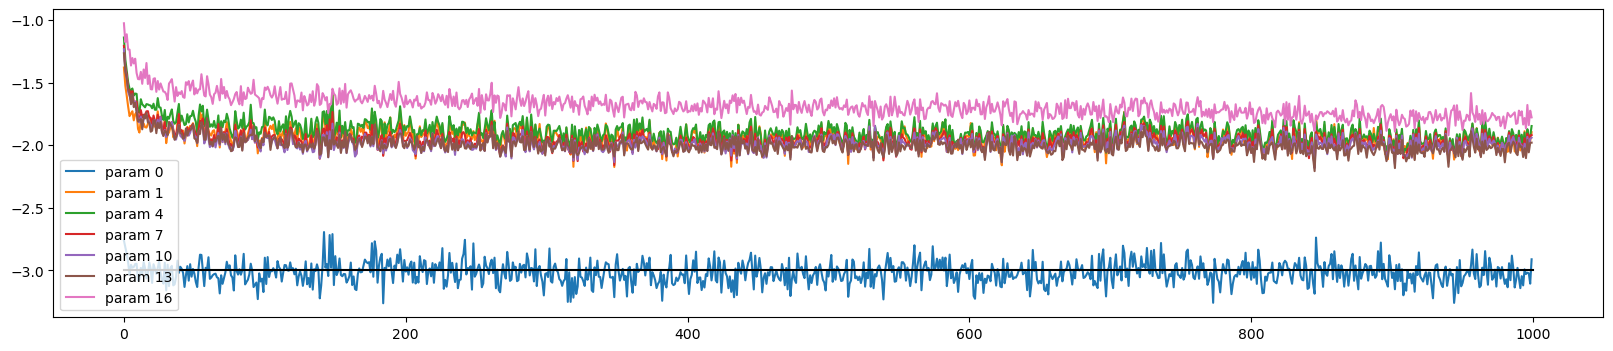

In [23]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [27]:
# We see that with lr = 0.1 we obtain a good learning, and the emb layer learns quicker than the rest.